# Sampling Random Fourier Feature functions from a 1-dimensional Gaussian Process
This example shows how to sample continuous functions from a 1-dimensional Gaussian process, via the Random Fourier Feature approximation method [[1]](https://arxiv.org/abs/1511.05467).

The notebook begins with the construction of a synthetic groundtruth, followed by Maximum a posteriori estimation and MCMC sampling of a Gaussian process model with [PyMC3](https://github.com/pymc-devs/pymc3).

GP hyperparameters (lengthscale, covariance scaling and observation standard deviation) are given to the `pyrff.sample_rff` function, to obtain `RffApproximation` objects.

The notebook assumes that you have a basic understanding of Gaussian processes already. Here are some videos that give the intuition relevant to this notebook:
+ [Vincent Warmerdam: Gaussian Progress | PyData Berlin 2019](https://youtu.be/aICqoAG5BXQ?t=1471)
+ [Christopher Fonnesbeck - Bayesian Non-parametric Models for Data Science using PyMC3 - PyCon 2018](https://www.youtube.com/watch?v=-sIOMs4MSuA)


<div style="text-align: right"> by <a href="https://github.com/michaelosthege">Michael Osthege</a></div>

In [1]:
import arviz
import fastprogress
from matplotlib import pyplot, cm
import numpy
import pymc3

import pyrff

## Specify Synthetic Problem
A `truth` function is defined, mapping `(?, 1)` input coordinates to `(?,)` output values. The `observe` function simulates evaluation of the groundtruth with a fixed normally distributed observation noise $y_{obs}(x) \sim \mathcal{N}(\texttt{truth}(x),\ \sigma_{true})$.

`X` coordinates for observations `Y` are sampled in with `BOUNDS` of interest using the `observe` function.

Note that the support of the Gaussian process model is in no way constrained by these bounds.

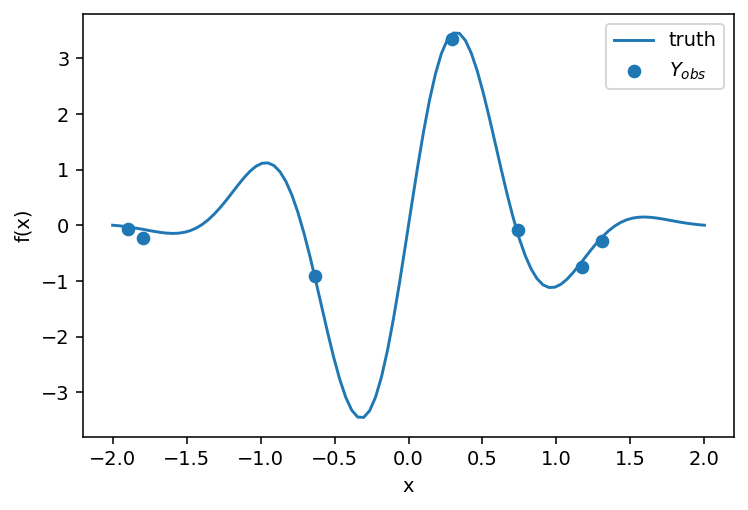

In [2]:
σ_true = 0.1
D = 1
BOUNDS = (-2, 2)

def truth(x):
    y = 3 * numpy.sin((1.5*numpy.pi)*x) + numpy.sin((1*numpy.pi)*x)
    return y * numpy.exp(-x**2)

def observe(x, sigma=σ_true):
    y = truth(x)
    return numpy.random.normal(y[:,0], sigma, size=(len(x),))

# make observations
X = numpy.random.RandomState(202005).uniform(
    low=BOUNDS[0],
    high=BOUNDS[1],
    size=(7,D)
)
Y = observe(X)

# create coordinates for plotting
x_dense = numpy.linspace(*BOUNDS, num=100)[:,None]

# visualize
if D == 1:
    fig, ax = pyplot.subplots(dpi=140)
    ax.plot(x_dense, truth(x_dense), label='truth')
    ax.scatter(X, Y, label='$Y_{obs}$')
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.legend()
    pyplot.show()

## Fit Gaussian Process with `PyMC3`
A variety of packages can be used to fit Gaussian process models. This example uses [PyMC3](https://github.com/pymc-devs/pymc3), because it can efficiently do MCMC sampling of the model parameters with gradient-based samplers such as NUTS.

When fitting a GP for sampling RFF approximations later on, it is important to use a __constant 0-mean function__, a __Matern or squared exponential kernel__ and a __Normal likelihood__, because the RFF method is currently only described with these constraints.

The GP model in the next cell is built from three free random variables:
+ $\texttt{ls} \sim Lognormal(log(\texttt{span}/2),\ \sigma=0.5)$ is a prior on the lenghscales, informed by the distance between the lower and upper bound
+ $\texttt{scaling} \sim Lognormal(log(\texttt{span}/10),\ \sigma=0.2)$ is a strongly informative prior on the amount of variance in the data we expect to explained by the underlying function
+ $\texttt{scaling} \sim Lognormal(log(\texttt{span}/10),\ \sigma=0.2)$ is a strongly informative prior on the standard deviation of the normally distributed observation noise

The Normal likelihood function is builtin to the `gp.marginal_likelihood` method of the [`pymc3.gp.Marginal`](https://docs.pymc.io/notebooks/GP-Marginal.html) class.

In [3]:
with pymc3.Model() as pmodel:
    # center the lengthscale prior on half of the space width
    ls = pymc3.Lognormal('ls', mu=numpy.log(numpy.ptp(BOUNDS) / 2), sd=0.5)
    
    # we expect the function to explain most of the variance, so center a prior
    # on the data amplitude
    scaling = pymc3.Lognormal('scaling', mu=numpy.log(numpy.ptp(Y)), sd=0.2)
    # observation noise of around 10 % of the data amplitude sounds realistic..
    sigma = pymc3.Lognormal('sigma', mu=numpy.log(numpy.ptp(Y) / 10), sd=0.2)

    # construct the GP
    # the literature describes RFFs only for 0 mean !!!
    mean_func = pymc3.gp.mean.Zero()
    cov_func = scaling**2 * pymc3.gp.cov.ExpQuad(
        input_dim=D,
        ls=ls
    )
    # the literature only describes RFFs for normally distributed observation noise
    # therefore, we can use gp.Marginal and don't need to use gp.Latent
    gp = pymc3.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    gp.marginal_likelihood('L', X, Y, noise=sigma)
        
with pmodel:
    mp = pymc3.find_MAP()
    
with pmodel:
    idata = arviz.from_pymc3(pymc3.sample(tune=1000, draws=1000))

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional i

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


### Inspecting the quality of the MCMC samples
The posterior samples are stored in the `idata` variable as an [ArviZ](https://arviz-devs.github.io/arviz/) `InferenceData` object. Using `arviz.plot_trace` we can visualize the the Markov chains. If the plots on the right look like random noise,  to see if something went terribly wrong. If the plots on the right look like random noise, chances are good. For more visualization options, see the [ArviZ gallery](https://arviz-devs.github.io/arviz/examples/index.html).

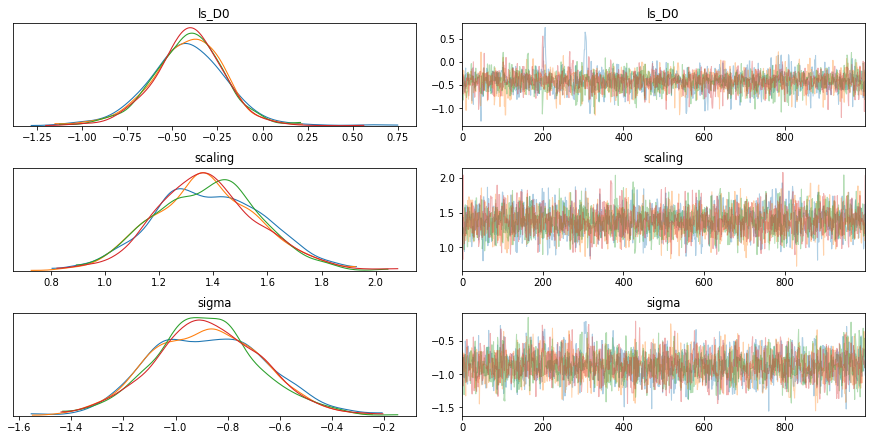

In [4]:
axs = arviz.plot_trace(idata, var_names=['ls', 'scaling', 'sigma'], transform=numpy.log)
for d, axr in zip(range(D), axs):
    dname = f'D{d}'
    for ax in axr:
        ax.set_title(f'ls_{dname}')
pyplot.show()

## Drawing observations from a GP model
While they are often portrayed as functions, we can not actually sample functions from a Gaussian process, but just evaluations of those functions at predefined coordinates.

To make those evaluations with the PyMC3 model, we have to add a `gp.conditional` to the model, giving it the x-coordinates on which to _condition_ the observations:

In [5]:
# add observations, conditioned on slices of x-coordinates to the model
with pmodel:
    gp.conditional('D0', Xnew=x_dense)

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


The next step is to sample the observations, using the model fit for the GP parameters.

The following cell samples 1000 times with the MAP estimate parameter set, and the cell after uses the posterior distribution of model parameters.

In [6]:
# sample the GP at those coordinates, using the MAP hyperparameters
with pmodel:
    pp_map = pymc3.sample_posterior_predictive(
        [mp]*1000,
        var_names=['D0'],
        random_seed=None
    )

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [7]:
# also sample the GPs created from hyperparameter posterior samples
with pmodel:
    pp_mcmc = pymc3.sample_posterior_predictive(
        idata.posterior,
        var_names=['D0'],
        random_seed=None
    )

## Sample RFF approximations
Just like the conditional samples from the GP model, sampling RFF approximations starts from GP parameter sets.

Furthermore, the `pyrff.sample_rff` function needs to know the degrees of freedom of the GPs kernel (e.g. $3/2$ for a Matern32 kernel, or $\infty$ for the squared exponential a.k.a. RBF kernel) and the number of fourier features $M$ to be used for the approximation.

The next cell samples $N$ `pyrff.RffApproximation` objects with $M$ features from the MAP estimate parameter set.

In [8]:
M = 200
N = 3000
rffs_map = [
    pyrff.sample_rff(
        lengthscales=mp['ls'],
        scaling=mp['scaling'],
        noise=mp['sigma'],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in fastprogress.progress_bar(range(N))
]

The next cell samples RFF approximations from the posterior distribution of parameter sets. It subsamples the posterior randomly to get just $N$ approximations, even if the MCMC ran with more `chains * draws`.

In [9]:
C = idata.posterior.dims['chain']
S = idata.posterior.dims['draw']
# subsample the posterior N times
posterior_indices = numpy.random.randint(
    low=0,
    high=C * S,
    size=N
)
rffs_mcmc = [
    pyrff.sample_rff(
        lengthscales=idata.posterior['ls'].values.reshape(C * S, D)[i],
        scaling=idata.posterior['scaling'].values.reshape(C * S,)[i],
        noise=idata.posterior['sigma'].values.reshape(C * S,)[i],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in fastprogress.progress_bar(posterior_indices)
]

## Compare RFF approximations with true conditional samples
We expect RFF approximations to have the same mean and variance as true Gaussian process samples. By comparing them side by side to the conditional GP samples, we can make that comparison visually.

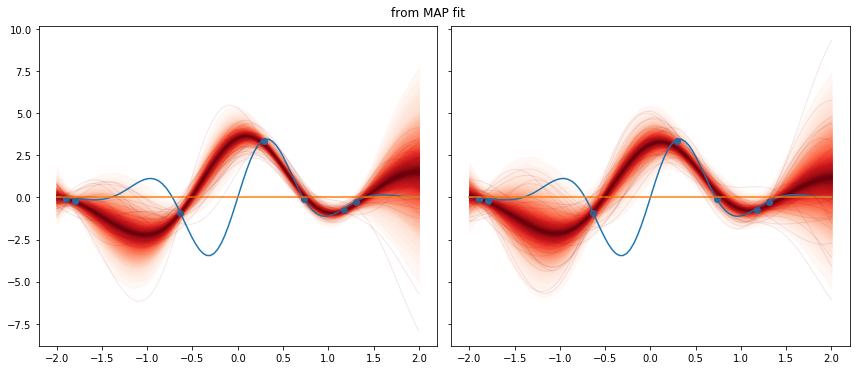

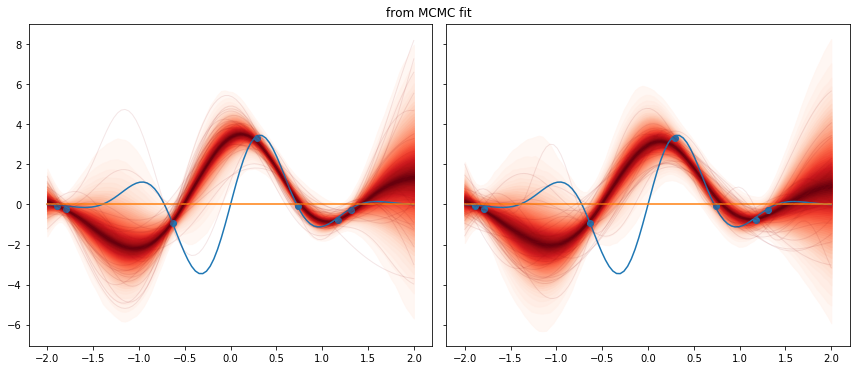

In [10]:
for label, pp, rffs in [
    ('MAP', pp_map, rffs_map),
    ('MCMC', pp_mcmc, rffs_mcmc),
]:

    fig, [(left, right)] = pyplot.subplots(nrows=1, ncols=2, figsize=(12, 5), squeeze=False, sharey='row')

    d = 0
    dname = f'D{d}'

    # plot functions
    for fname, f in [
            ('truth', truth),
            ('GP mean function', lambda x: gp.mean_func(x).eval())
        ]:
        left.plot(x_dense[:,d], f(x_dense), label=fname)
        right.plot(x_dense[:,d], f(x_dense), label=fname)

    # plot conditionals and approximations
    pymc3.gp.util.plot_gp_dist(left, pp[dname], x_dense[:,d])
    pymc3.gp.util.plot_gp_dist(right, numpy.array([
        f_rff(x_dense)
        for f_rff in rffs
    ]), x_dense[:,d])

    if D == 1:
        left.scatter(X[:,d], Y, label='$Y_{obs}$')
        right.scatter(X[:,d], Y, label='$Y_{obs}$')

    axs[0,0].set_title('conditionals')
    axs[0,1].set_title('RFF approximations')
    fig.suptitle(f'from {label} fit', y=1.02)
    fig.tight_layout()
    pyplot.show()

## Run optimization on the RFF approximations to obtain $p(x_* \mid X, Y)$ samples
The big advantage of RFF approximations over true conditional GP samples is that they are continuous functions.
Because they can be evaluated repeatedly, they can be visualized more efficiently. But most importantly, iterative optimization can be applied to find local, or global optima.

In the context of Bayesian optimization, Thompson sampling is a popular method for drawing design points in a way that minimizes the long-term cumulative regret. The algorithm boils down to making random draws from the posterior distribution over the global optimum $p(x_* \mid X,Y)$.

At this point, we have not yet sampled from $p(x_* \mid X,Y)$, but just approximate samples from $f \sim GP(0, k(x,x'))$.

To obtain $x_*$ samples, we can simply run optimization on the sampled functions:

In [11]:
x_star = {}
for label, pp, rffs in [
    ('MAP', pp_map, rffs_map),
    ('MCMC', pp_mcmc, rffs_mcmc),
]:
    
    print(f'Minimizing RFFs obtained from {label} fit')

    # collect minima for all RFF functions
    x_star_x = []
    x_star_y = []
    for f_rff in fastprogress.progress_bar(rffs):
        x_best, y_best = pyrff.multi_start_fmin(
            fun=f_rff,
            x0s=numpy.random.uniform(low=BOUNDS[0], high=BOUNDS[1], size=(50, D)),
        )
        x_star_x.append(x_best)
        x_star_y.append(y_best)
    x_star[label] = (numpy.array(x_star_x), numpy.array(x_star_y))

Minimizing RFFs obtained from MAP fit


Minimizing RFFs obtained from MCMC fit


Before interpreting the following plots, it is important to keep in mind that the Gaussian process is not concerned about the bounds we have defined earlier. We have initialized the local optimization with the `BOUNDS`, but did not constrain it to stay within, giving us many $x_*$ that are outside of the bounds.

The Gaussian process naturally converges back to its prior, the further away it is from observations. Its support is $x \in \mathcal{R}^D$, so if for some reason you do not want to explore conditions outside of your bounds, you must critically think about how you want to enforce that constraint in your Bayesian optimization problem.

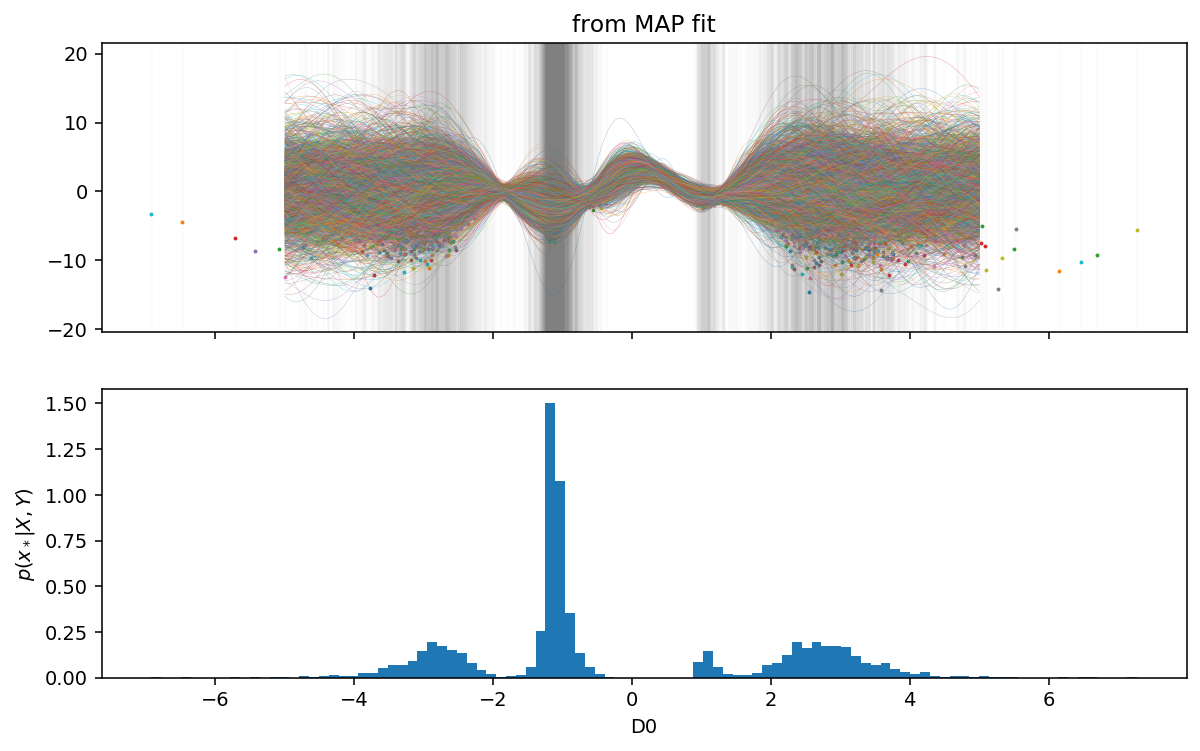

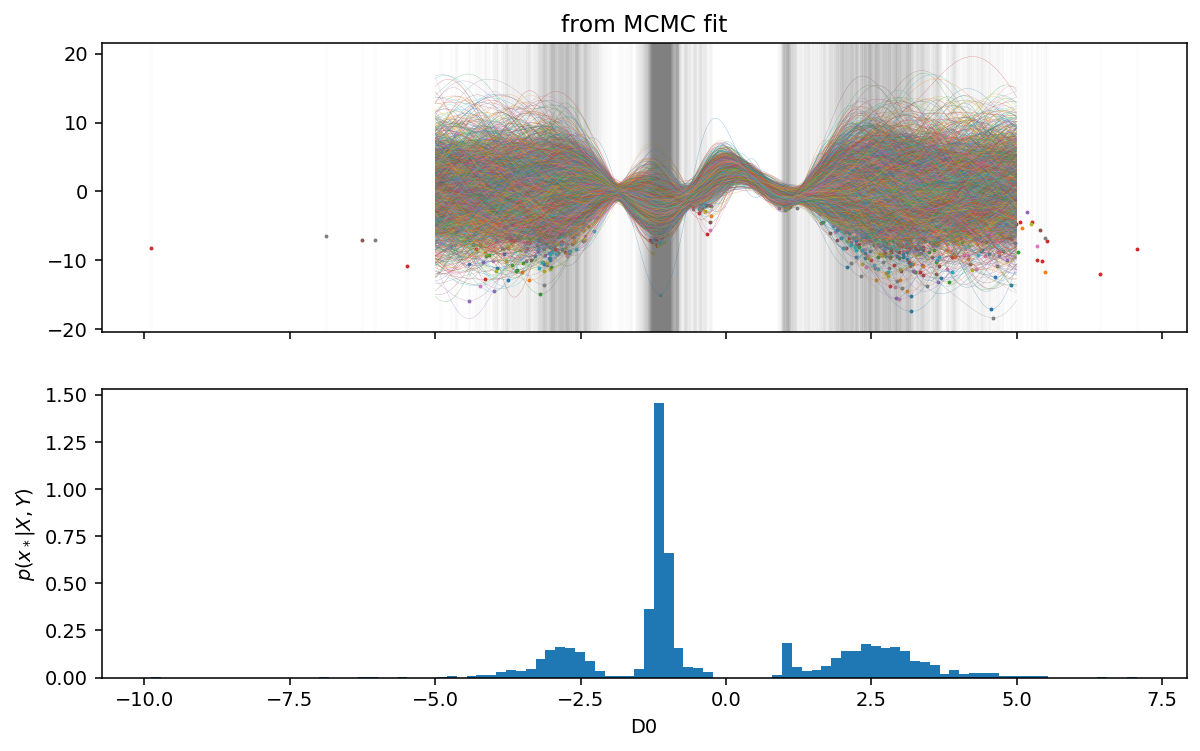

In [12]:
if D == 1:
    for l, (label, (x_star_x, x_star_y)) in enumerate(x_star.items()):
        fig, (ax, axh) = pyplot.subplots(dpi=140, nrows=2, sharex='col', figsize=(10, 6))
        x_dense = numpy.linspace(-5,5, 500)[:,numpy.newaxis]
    
        ax.set_title(f'from {label} fit')
        for f_rff, best_x, best_y in zip(rffs, x_star_x, x_star_y):
            ax.plot(
                x_dense,
                f_rff(x_dense),
                linewidth=0.1,
            )
            ax.axvline(best_x, color='grey', alpha=0.02)
            ax.scatter(
                [best_x],
                [best_y],
                s=1
            )
        axh.hist(numpy.array(x_star_x)[:,0], bins=100, density=True)
        axh.set_ylabel('$p(x_*|X,Y)$')
        axh.set_xlabel('D0')
        pyplot.show()

## Save the RFFs to a file
`pyrff` implements functions to save and load a list of `RffApproximation` objects to and from an HDF5 file. You might want to do this to run optimization or visualization in other scripts/notebooks.

In [13]:
pyrff.save_rffs(rffs_map, '1D_MAP_rffs.h5')
pyrff.save_rffs(rffs_map, '1D_MCMC_rffs.h5')

'1D_MCMC_rffs.h5'